# Results Atlas-based Registration
In this notebook, the results of the atlas-based registration are visualized. 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# from statannotations.Annotator import Annotator
from scipy import stats

import random
from pathlib import Path

import numpy as np
import torch
import SimpleITK as sitk
import torchvision
from matplotlib import pyplot as plt

import u_net
import utils

In [3]:
def smooth_segmentation(dataloader, model):
    predictions = []
    with torch.no_grad():
        torch.manual_seed(42)
        for (img, _) in dataloader:
            output = torch.sigmoid(model(img[np.newaxis, ...]))
            predictions.append(output)
        full_prostate = torch.stack(predictions, dim=0).squeeze().squeeze()
        blur = torchvision.transforms.GaussianBlur(9, sigma=2)
        smooth_prostate = torch.round(blur(full_prostate))
    return smooth_prostate

def dice_coefficient(output, target):
    intersection = (output * target).sum()
    dice = (2.0 * intersection + 1) / (
        output.sum() + target.sum() + 1
    )
    return dice

In [4]:
# to ensure reproducible training/validation split
random.seed(42)
torch.manual_seed(42)

# directorys with data and to stored training checkpoints
DATA_DIR = Path.cwd().parent.parent / "DevelopmentData"
CHECKPOINTS_DIR_BASELINE = Path.cwd() / "segmentation_model_weights" / f"u_net_baseline.pth"
CHECKPOINTS_DIR_CVAE = Path.cwd() / "segmentation_model_weights" / f"u_net_cvae.pth"

# hyperparameters
NO_VALIDATION_PATIENTS = 2
IMAGE_SIZE = [64, 64]

# find patient folders in training directory
# excluding hidden folders (start with .)
patients = [
    path
    for path in DATA_DIR.glob("*")
    if any(part.startswith("p") for part in path.parts)
]
random.shuffle(patients)

# split in training/validation after shuffling
partition = {
    "train": patients[:-NO_VALIDATION_PATIENTS],
    "validation": patients[-NO_VALIDATION_PATIENTS:],
}

# load validation data
valid_dataset = utils.CombinedProstateMRDataset(partition["validation"], [], IMAGE_SIZE)
total_prostate, total_segment = next(iter(valid_dataset))

unet_baseline = u_net.UNet(num_classes=1)
unet_baseline.load_state_dict(torch.load(CHECKPOINTS_DIR_BASELINE))
unet_baseline.eval()

unet_cvae = u_net.UNet(num_classes=1)
unet_cvae.load_state_dict(torch.load(CHECKPOINTS_DIR_CVAE))
unet_cvae.eval()

p1  = utils.CombinedProstateMRDataset([partition["validation"][0]], [], IMAGE_SIZE, valid=True)
p2  = utils.CombinedProstateMRDataset([partition["validation"][1]], [], IMAGE_SIZE, valid=True)

Patient 1 mean: 0.7461, std: 0.3079
Patient 2 mean: 0.6703, std: 0.3559


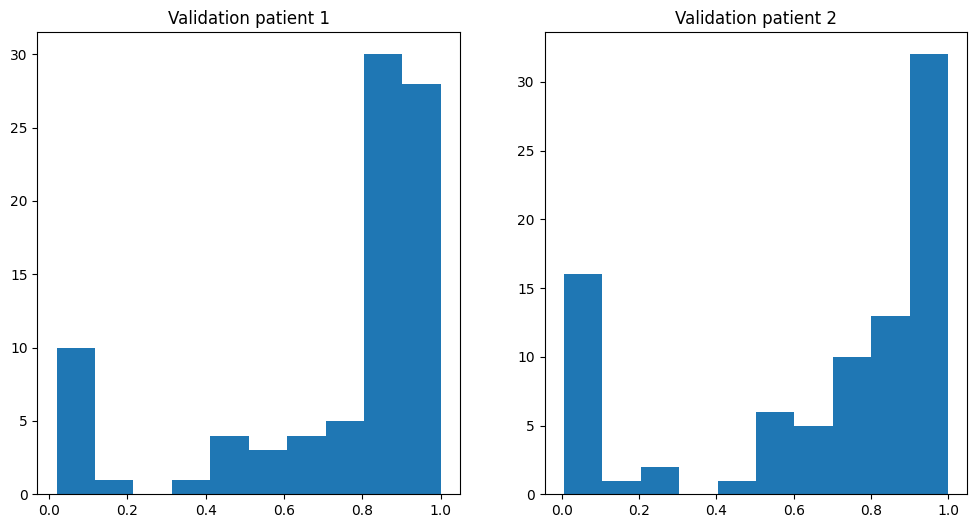

In [5]:


prediction_p1_b = smooth_segmentation(p1, unet_baseline)
prediction_p2_b = smooth_segmentation(p2, unet_baseline)
dice1_b = [dice_coefficient(prediction_p1_b[i], p1[i][1]) for i in range(len(p1))]
dice2_b = [dice_coefficient(prediction_p2_b[i], p2[i][1]) for i in range(len(p2))]

print(f"Patient 1 mean: {np.mean(dice1_b):.4f}, std: {np.std(dice1_b):.4f}")
print(f"Patient 2 mean: {np.mean(dice2_b):.4f}, std: {np.std(dice2_b):.4f}")
plt.figure(figsize = (12,6))
plt.subplot(121)
plt.title("Validation patient 1")
plt.hist(dice1_b)
plt.subplot(122)
plt.title("Validation patient 2")
plt.hist(dice2_b)
plt.show()

Patient 1 mean: 0.8390, std: 0.2401
Patient 2 mean: 0.5889, std: 0.3354


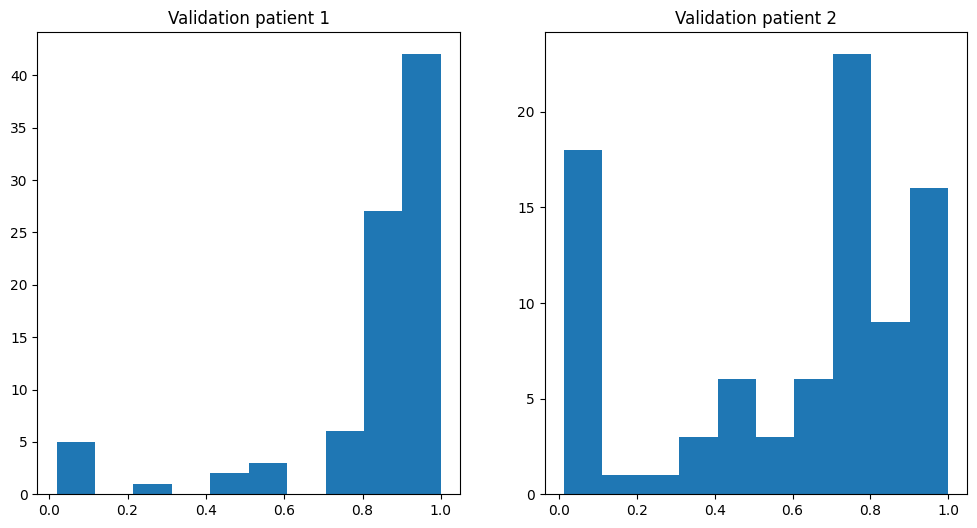

In [11]:
prediction_p1_c = smooth_segmentation(p1, unet_cvae)
prediction_p2_c = smooth_segmentation(p2, unet_cvae)
dice1_c = [dice_coefficient(prediction_p1_c[i], p1[i][1]) for i in range(len(p1))]
dice2_c = [dice_coefficient(prediction_p2_c[i], p2[i][1]) for i in range(len(p2))]

print(f"Patient 1 mean: {np.mean(dice1_c):.4f}, std: {np.std(dice1_c):.4f}")
print(f"Patient 2 mean: {np.mean(dice2_c):.4f}, std: {np.std(dice2_c):.4f}")
plt.figure(figsize = (12,6))
plt.subplot(121)
plt.title("Validation patient 1")
plt.hist(dice1_c)
plt.subplot(122)
plt.title("Validation patient 2")
plt.hist(dice2_c)
plt.show()

Baseline total mean: 0.7082, total std: 0.3349
CVAE total mean: 0.7139, total std: 0.3173


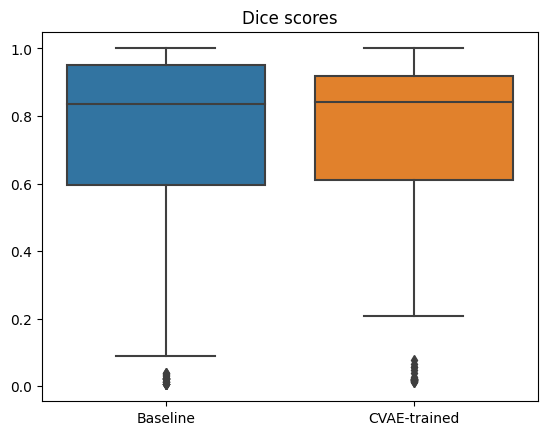

In [ ]:
total_dice_b = dice1_b + dice2_b
total_dice_c = dice1_c + dice2_c
print(f"Baseline total mean: {np.mean(total_dice_b):.4f}, total std: {np.std(total_dice_b):.4f}")
print(f"CVAE total mean: {np.mean(total_dice_c):.4f}, total std: {np.std(total_dice_c):.4f}")
sns.boxplot([total_dice_b, total_dice_c]).set_title("Dice scores")
plt.xticks(plt.xticks()[0], ["Baseline", "CVAE-trained"]);


c:\Users\20182717\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20182717\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


AttributeError: Rectangle.set() got an unexpected keyword argument 'sharey'

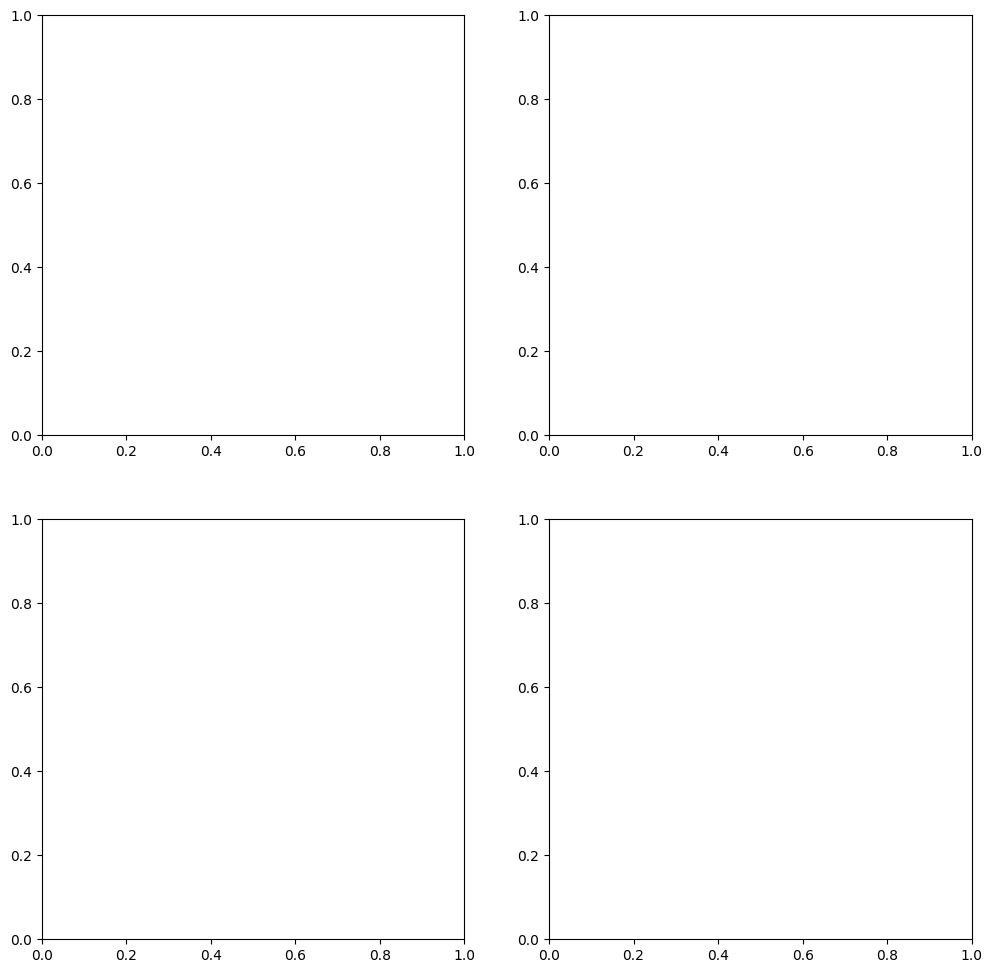

In [ ]:
# Check for normality of dice scores
names = ["Baseline", "CVAE-trained"]
alpha = 0.05
fig, ax = plt.subplots(2, 2, figsize=(12, 12));
for idx, dice in enumerate([total_dice_b, total_dice_c]):
    # Plot histogram
    sns.histplot(np.array(dice), kde=True, color="Blue", ax=ax[0,idx]);
    stats.probplot(np.array(dice), dist="norm", plot=ax[1,idx]);
    ax[0,idx].set_title(names[idx], fontsize=16);

    # Compute Shapiro-Wilk test
    stat, pval = stats.shapiro(dice);
    if pval > alpha:
        print(f"{names[idx]} experiment is likely normally distributed (fail to reject H0).")
        print(f"p-value = {pval:.3f}")
        print("------")
    else:
        print(f"{names[idx]} experiment is NOT normally distributed (reject H0).")
        print(f"p-value = {pval:.3f}")
        print("------")

In [50]:
import scipy
p_wilcox = scipy.stats.wilcoxon(total_dice_b, total_dice_c)
print(p_wilcox)

WilcoxonResult(statistic=4591.0, pvalue=0.4742714823423504)
